# Analysis #3: Repartition of Oskar in organ tissues and developmental stages
- Author: Savandara BESSE & Leo BLONDEL
- Creation: 06-20-2017
- Last modification : 11-01-2019


### Required inputs
- ./Data/01_Oskar_identification/2019/transcriptome_insect_database.csv

### Description
Identifies the tissues and developmental stages where oskar was found in transcriptomes. The initial collection of metadata are extracted from the description of Biosample projects. Consensus keywords were created for redundant tissues and developmental stages. 
The results of this analysis can be visualized in Figure 3.  

### Generated outputs
Available in `./Data/02_Oskar_analyses/2.3/`
- 2.3.1.insect_metadata_biosample_database.csv
- 2.3.2.oskar_all_tissues_stages.csv
- 2.3.3.oskar_all_tissues.csv
- 2.3.4.oskar_all_stages.csv

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json, lxml, math, matplotlib, os, progressbar, re, time

from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup
from fuzzywuzzy import process

from Bio import Entrez
Entrez.email = 'your@email.here' #Use your own email

data_path = '../Data/02_Oskar_analyses/'
%matplotlib inline

In [6]:
import bs4
bs4.__version__

'4.8.1'

In [4]:
TSA_infos = pd.read_csv('../Data/01_Oskar_identification/2019/transcriptome_insect_database.csv')

__/!\ If TSA tissue and stage table not provided__
## Step 1: Create tissue and stage table (extracted from Biosample database)

In [13]:
def tidy_Table(tsa):
    tsa_id = []
    TSA = []
    bioproject = []
    biosample_list = []

    index = -1
    tsa['biosample'] = tsa['biosample'].apply(str)
    for sample in tsa['biosample']:
        if 'nan' != sample :
            index += 1
            sample = sample.split(',')
            tsa_ID = tsa['tsa_id'][index][:4]
            for elem in sample :
                TSA.append(tsa['tsa_id'][index])
                tsa_id.append(tsa_ID)
                bioproject.append(tsa['bioproject'][index])
                biosample_list.append(elem)
        else: 
            sample = 'na'
            tsa_ID = tsa['tsa_id'][index][:4]
            TSA.append(tsa['tsa_id'][index])
            tsa_id.append(tsa_ID)
            bioproject.append(tsa['bioproject'][index])
            biosample_list.append(sample)
        
    result = [TSA, tsa_id, bioproject, biosample_list]
    TSA_metadata = pd.DataFrame(data=result, index=['TSA','tsa_id', 'bioproject','biosample']).T
    TSA_metadata = TSA_metadata[TSA_metadata.biosample != 'na']
    return TSA_metadata

def collect_Infos(TSA_DF):  
    results = []
    bar = progressbar.ProgressBar(widgets=[' [', progressbar.Timer(), '] ', progressbar.Bar(), ' (', progressbar.ETA(), ')', ])
    for i in bar(TSA_DF.index):
        TSA = TSA_DF['TSA'][i]
        tsa_id = TSA_DF['tsa_id'][i]
        bioproject = TSA_DF['bioproject'][i]
        sample = TSA_DF['biosample'][i]
        time.sleep(0.5)
        bio_handle = Entrez.esearch(db="biosample", term=sample)
        record = Entrez.read(bio_handle)['IdList']
        handle = Entrez.esummary(db="biosample", id=record[0])
        summary = Entrez.read(handle)['DocumentSummarySet']['DocumentSummary']

        for tag in summary :
            soup = BeautifulSoup(tag['SampleData'], 'lxml')
            attributes = soup.find_all('attribute')
            tmp = []
            for elem in attributes :
                for child in elem.children :
                    if elem['attribute_name'] == 'sex' :
                        tmp.append([TSA, tsa_id, bioproject, sample, child.lower(), None, None])
                    if elem['attribute_name'] == 'dev_stage' :
                        tmp.append([TSA, tsa_id, bioproject, sample, None, child.lower(), None])
                    if elem['attribute_name'] == 'sample-type':
                        tmp.append([TSA, tsa_id, bioproject, sample, None, None, child.lower()])
                    if elem['attribute_name'] == 'tissue':
                        tmp.append([TSA, tsa_id, bioproject, sample, None, None, child.lower()])
                    if elem['attribute_name'] == 'tissue_type':
                        tmp.append([TSA, tsa_id, bioproject, sample, None, None, child.lower()])
            if tmp:
                for el in tmp:
                    results.append(el)
            else:
                results.append([TSA, tsa_id, bioproject, sample, None, None, None])
    TSA_all_infos = pd.DataFrame(data=results, columns=['TSA','tsa_id', 'bioproject','biosample','sex', 'stage','tissue'])
    return TSA_all_infos

In [15]:
TSA_metadata = collect_Infos(tidy_Table(TSA_infos))

 [Elapsed Time: 2:09:24] |####################################| (Time: 2:09:24)


In [16]:
TSA_metadata.to_csv(os.path.join(data_path, '2.3/insect_metadata_biosample_database.csv'), sep=",",encoding="utf-8", header=True, index=False, na_rep='None')

## Step 2: Keywords curation for tissue, stages and sex

In [13]:
tissue_mapping = {
    'None':'None',
    'whole insects':'whole organism',
    'regurgitant':'None',
    'central nervous system':'brain',
    'abdominal fat body':'fat body',
    'female thorax':'thorax',
    'male thorax':'thorax',
    'male other accessory glands':'accessory glands',
    'female spermatophore digesting gland / bursa':'bursa',
    'male spiral gland':'spiral gland',
    'female spermatheca':'spermatheca',
    'whole organism':'whole organism',
    'head, thorax, forelegs':' & '.join(['head', 'thorax', 'forelegs']),
    'silk glands':'silk glands',
    'whole fly':'whole organism',
    'light organ':'light organ',
    'whole larva excluding light organ':'whole organism',
    'midgut':'midgut',
    'malpighian tubules':'malpighian tubules',
    'fat body':'fat body',
    'testicle pair':'testes',
    'ovary':'ovaries',
    'head and thorax':' & '.join(['head','thorax']),
    'whole body':'whole organism',
    'missing':'undetermined tissue',
    'abdomen':'abdomen',
    'entire organism':'whole organism',
    'bursa':'bursa',
    'bursal gland':'bursa',
    'thorax':'thorax',
    'whole animal':'whole organism',
    'fat body, reproductive tissues':' & '.join(['fat body', 'reproductive tissues']),
    'brain':'brain',
    'testis':'testes',
    'various':'undetermined tissue',
    'antennae, legs and larvae':' & '.join(['antennae', 'legs','larvae']),
    'head':'head',
    'antennae':'antennae',
    'heads':'head',
    'venom apparatus':'venom apparatus',
    'body without venom gland':'whole organism',
    'whole larvae':'whole organism',
    'entire body':'whole organism',
    'flight muscle':'muscle',
    'whole heads':'head',
    'males without ovaries or head':'whole organism',
    'females without ovaries or head':'whole organism',
    'muscle (abdominal)':'muscle',
    'testes':'testes',
    'ovaries':'ovaries',
    'fatbody':'fat body',
    'brain/head':'brain',
    'brain (heads with antennae)':' & '.join(['head','antennae']),
    'egg / embryo':'egg',
    'whole larva':'whole organism',
    'brain (heads)':'brain',
    'muscle (from abdomen)':'muscle',
    'salivary glands':'salivary glands',
    'not applicable':'undetermined tissue',
    'salivary gland':'salivary glands',
    'midgut head':'midgut',  
    'whole individual':'whole organism',
    'ovarian':'ovaries',
    'whole insect':'whole organism',
    'hemocytes':'blood', 
    'mouthpart':'mouthpart',
    'tarsus':'tarsus',
    'pupal head':'head',
    'antenna':'antennae',
    'venom gland and venom sac':' & '.join(['venom gland','venom sac']),
    'whole larvae body':'whole organism',
    'pheromone gland':'pheromone gland',    
    'prothoracic gland':'prothoracic gland', 
    'whole':'whole organism',
    'anterior midgut':'midgut',
    'cns':'brain',
    'foregut':'foregut',
    'whole midge':'whole organism', 
    'head+thorax':' & '.join(['head','thorax']),
    'entire thorax':'thorax',
    'body':'whole organism', 
    'hemocyte':'blood',
    'neuron':'brain', 
    'the fat body and the ovary':' & '.join(['fat body', 'ovaries']),
    'wing of the nymph':'wing',
    'italy':'undetermined tissue',   
    'venom gland':'venom gland',
    'adult':'whole organism',
    'bacteriome':'undetermined tissue',
    'whole body (minus bacteriome)':'whole organism', 
    'whole female adults, venom glands and female body carcasses':'whole organism',
    'midgut unfed':'midgut',
    'blood fed midgut':'midgut',
    'full':'whole organism',
    'maxillary palps':'maxillary palps',
    'male heads':'head',
    'egg':'egg',
    'laves_stage_3-4':'whole organism',
    'larval':'whole organism',
    'larva':'whole organism',
    'pupae':'whole organism',
    'egg0-24h':'egg',
    'reproductive tract': 'reproductive organs',
    'reproductive organs':'reproductive organs',
    'multi':'undetermined tissue',
    'adult female antennae':'antennae',
    'adult male antennae':'antennae',
    'adult whole females':'whole organism',
    'adult whole males':'whole organism',
    'single whole larva':'whole organism',
    'pooled whole organism':'whole organism',
    'brains':'brain',
    'proboscises':'proboscises',
    'rostrums':'rostrums',
    'abdominal tips':'abdominal tips',
    'hindlegs':'hindlegs',
    'midlegs':'midlegs',
    'forelegs':'forelegs',
    'whole gut':'gut',
    'gut, fat body, malpighian tubules, glands':' & '.join(['gut', 'fat body', 'malpighian tubules', 'glands']),
    'posterior abdomen':'abdomen',
    'eggs, larvae, pupae and adults':'whole organism',
    'integument':'integument',
    'bacteriocyte':'undetermined tissue',
    'whole adult insect':'whole organism',
    'legs':'legs',
    'wing disc':'wing',
    'gut':'gut',
    'adults, nymphs, guts':'gut',
    'head and 6 legs': 'head',
    'head and forelegs': 'head',
    '1 leg':'leg',
    '3 legs':'leg',
    "head and prothorax": "head & prothorax",
    "larval head": "head",
    "whole body tisue": "whole organism",
    "large globular cells": "large globular cells",
    "body carcass without embryos": "whole organism",
    "whole body without gut": "whole organism",
    "whole body tissue": "whole organism",
    "mid-gut": "midgut",
    "head and abdomen": "head & abdomen",
    "whole cricket": "whole organism",
    "prothorax": "prothorax",
    "the whole body after head, wings and gut were removed": "whole organism",
    "egg & larvae": "egg & larvae",
    "head horn": "head",
    "thorax horn": "thorax",
    "whole adult": "whole organism",
    "whole insect tissue": "whole organism",
    "head/legs/thorax": "head & legs & thorax",
    "entire individual": "whole organism",
    "leg": "leg",
    "whole individual preps": "whole organism",
    "thoracic gland": "thoracic gland",
    "adult body": "whole organism",
    "entire insect": "whole organism",
    "central nervous system (cns)": "brain",
    "throax,head": "head & thorax",
    "neuronal, prothoracic ganglion": "brain",
    "ehad": "brain",
    "tisue (mostly muscle)": "muscle",
    "mixed": "whole organism",
    "whole bodies": "whole organism",
    "adult thorax": "thorax",
    "tisuue (mostly muscle)": "muscle",
    "accessory gland": "accessory gland",
    "carcass": "whole organism",
    "whole eggs": "egg",
    "embryonic foreleg": "foreleg",
    "embryonic midleg": "midleg",
    "embryonic hindleg": "hindleg",
    "venom gland and venom reservoir": "venom gland",
    "wing, eyespot in m3 wing sector": "wing",
    "wing, eyespot in cu1 wing sector": "wing"
}

stage_mapping = {
    '1st instar larva (1d post molt)':'1st instar larvae',
    '2nd instar heads (1day post-molt)':'2nd instar larvae',
    '2nd instar larva (1d post molt)':'2nd instar larvae', 
    '2nd instar larvae':'2nd instar larvae',
    '3nd instar larva (1d post molt)':'3rd instar larvae',
    '3rd instar heads (1day post-molt)':'3rd instar larvae', 
    '3rd/4th instar nymphs':' & '.join(['3rd instar larvae','4th instar larvae']),
    '4th _ early instar heads (molt within 12h)':'4th instar larvae',
    '4th _ late instar heads (when head capsule slipped)':'4th instar larvae', 
    '5th instar':'5th instar larvae',
    '5th instar larvae':'5th instar larvae', 
    '5th instar nymph':'5th instar nymph', 
    'None':'None', 
    'adult':'adult',
    'adult - early (1 day post eclosion)':'adult',
    'adult - early (1-3 days post eclosion)':'adult',
    'adult - early - (1 day post eclosion) - ovaries':'adult',
    'adult - early - (1-3 days post eclosion) - testes':'adult',
    'adult - early- mid age (3-5 days post eclosion)':'adult',
    'adult - mid age (7-9 days post eclosion)':'adult',
    'adult - middle age (3 days post eclosion)':'adult',
    'adult - middle age (7 days post eclosion)':'adult', 
    'adult female':'adult',
    'adult male':'adult', 
    'adult nurse':'adult', 
    'adults':'adult',
    'adults and fifth instar nymphs':' & '.join(['adult','5th instar nymph']), 
    'adults and third instar larvae':' & '.join(['adult','3rd instar larvae']),
    'all':'all stages', 
    'all development stages':'all stages', 
    'crawlers':'larvae',
    'crawlers after settlement':'larvae', 
    'early egg (laid within 3h)':'egg', 
    'egg':'egg',
    'egg to adult':'all stages', 
    'eggs, larva 1 to 5 and adusts':'all stages',
    'eggs, larvae, pupae, and adults':'all stages', 
    'fifth instar':'5th instar larvae',
    'fourth instar larvae':'4th instar larvae', 
    'imago':'imago',
    'juvenil':'juvenil', 
    'l3 l4':' & '.join(['3rd instar larvae','4th instar larvae']),
    'l5 larvae, pupae and adults':'all stages', 
    'larva':'larvae', 
    'larvae':'larvae',
    'larvae; pupae; adults':'all stages', 
    'larval':'larvae', 
    'larval (neonate)':'larvae',
    'larval - 3rd instar late (when head capsule slipped)':'4th instar larvae',
    'larval - 4th instar - late (post head capsule slippage)':'4th instar larvae',
    'larval - 4th instar early (molt within 12h)':'4th instar larvae',
    'larval - 4th instar late (when head capsule slipped)':'4th instar larvae',
    'larval - 5th instar (wandering stage)':'5th instar larvae',
    'larval - 5th instar - early (1 day post-molt)':'5th instar larvae',
    'larval - 5th instar (wandering stage)':'5th instar larvae',
    'larval - 5th instar - (wandering stage)':'5th instar larvae',
    'larval - 5th instar - early (within 12 h post-molt)':'5th instar larvae',
    'larval - 5th instar - late (pre-wandering)':'5th instar larvae',
    'larval - 5th instar early (1-3 h post molt)':'5th instar larvae',
    'larval - 5th instar early (24h post molt)':'5th instar larvae',
    'larval - 5th instar early (molt within 12h)':'5th instar larvae',
    'larval - 5th instar late (before wandering)':'5th instar larvae',
    'larval - 5th instar late (pre-wandering)':'5th instar larvae',
    'larval - 5th instar wandering':'5th instar larvae',
    'larval - early 4th instar (immediately post molt) - oral - mock infected - (stress control)' : '4th instar larvae',
    'larval, pupal, adult':'all stages',
    'larval-5th - early instar heads (molted within 12h)':'5th instar larvae',
    'larval-5th - mid instar heads (2d after molting)':'5th instar larvae',
    'larval-5th - pre-wandering heads':'5th instar larvae', 
    'late egg (before hatch)':'egg',
    'missing':'undetermined stage', 
    'nymph':'nymph', 
    'nymphs':'nymph', 
    'nymphs and adults':' & '.join(['nymph','adult']), 
    'pupa':'pupae', 
    'pupae':'pupae',
    'pupal':'pupae', 
    'pupal - early (1 day post pupation)':'pupae',
    'pupal - early (1-3d old)':'pupae',
    'pupal - early (3 days post pupation)- testes':'pupae',
    'pupal - late (15-18 days post pupation)':'pupae',
    'pupal - late - (15-18 days post pupation)- testes':'pupae',
    'pupal - late - (15-18 days post pupation) - ovaries':'pupae',
    'pupal - pharate (before eclosion)':'pupae', 
    'soon after fertilization':'egg',
    'third-instars larvae of moths':'3rd instar larvae',
    '5th instar caterpillar, nd population, brassica diet': '5th instar larvae',
    "prepupa": "pupae",
    "1day pupa": "pupae",
    "juvenile": "adult",
    "developmental; pre-hatch": "",
    "lfi1": "larvae",
    "lfi2": "larvae",
    "lfi3": "larvae",
    "plfi1": "pupae",
    "plfi2": "pupae",
    "plfi3": "pupae",
    "tlfi1": "adult",
    "tlfi2": "adult",
    "tlfi3": "adult",
    "worker": "adult",
    "reproductive": "adult",
    "1st instar nymph": "nymph",
    "middle instar individual": "larvae",
    "embryo": "embryo",
    "adults and nymphs": "adult & nymph",
    "adult + juvenile pooled": "adult",
    "unknown": "None",
    "male": "None",
    "not collected": "None",
    "mixed individuals": "adult",
    "larvae of first instar stage": "larvae",
    "larvae of fifth instar stage": "larvae",
    "mixed": "adult",
    "4th instar larvae": "larvae",
    "white pupae": "pupae",
    "adults, pupae, first- to third-instar larvae and eggs": "adult & pupae & larvae & egg",
    "fourth instar": "larvae",
    "pharate pupa (prepupa)": "pupae",
    "old worker": "adult",
    "1st instar larva": "larvae",
    "fifth-instar first day": "larvae",
    "early pupa (3-6h after pupation)": "pupae",
    "": "None"
}

sex_mapping = {
    'missing':'undetermined sex',
    'None':'None',
    'not determined':'undetermined sex',
    'not collected':'undetermined sex',
    'pooled male and female':'pooled sex',
    'female':'female',
    'male':'male',
    'not applicable':'undetermined sex',
    'male and female':'pooled sex',
    'mixed':'pooled sex',
    'indeterminate at this stage':'undetermined sex',
    'mixed sex':'pooled sex', 
    'na':'undetermined sex', 
    '-':'undetermined sex', 
    'neuter':'neuter', 
    'mix':'pooled sex', 
    'hermaphrodite':'hermaphrodite',
    'male and femaile':'pooled sex', 
    'pooled males and females':'pooled sex', 
    'f':'female',
    'm':'male',
    'undetermined':'undetermined sex',
}

cleaned_stage_mapping = {
    'larvae': [0, 1, 0, 0, 0],
    'None': [0, 0, 0, 0, 0],
    'adult': [0, 0, 0, 0, 1],
    'all stages': [1, 1, 1, 1, 1],
    'juvenil': [0, 0, 0, 1, 0],
    '5th instar nymph': [0, 0, 0, 1, 0],
    '3rd instar larvae & 4th instar larvae': [0, 1, 0, 0, 0],
    '4th instar larvae': [0, 1, 0, 0, 0],
    '5th instar larvae': [0, 1, 0, 0, 0],
    'pupae': [0, 0, 1, 0, 0],
    '2nd instar larvae': [0, 1, 0, 0, 0],
    '3rd instar larvae': [0, 1, 0, 0, 0],
    'egg': [1, 0, 0, 0, 0],
    '1st instar larvae': [0, 1, 0, 0, 0],
    'nymph': [0, 0, 0, 1, 0],
    'adult & 3rd instar larvae': [0, 1, 0, 0, 1],
    'undetermined stage': [0, 0, 0, 0, 0],
    'embryo': [1, 0, 0, 0, 0],
    'adult & nymph': [0, 0, 0, 1, 1],
    'adult & pupae & larvae & egg': [1, 1, 1, 0, 1],
    'imago': [0, 0, 0, 0, 1],
    'nymph & adult': [0, 0, 0, 1, 1],
    'adult & 5th instar nymph': [0, 0, 0, 1, 1],
    '': [0, 0, 0, 0, 0]
}

def tissue_map(s):
    if s not in tissue_mapping:
        if s not in done:
            print(s)
            done.append(s)
    else:
        return tissue_mapping[s]

def stage_map(s):
    s = s.replace('  ',' ')
    if s not in stage_mapping:
        if s not in done:
            print(s)
            done.append(s)
    else:
        return stage_mapping[s]

def sex_map(s):
    s = s.replace('  ',' ')
    if s not in sex_mapping:
        if s not in done:
            print(s)
            done.append(s)
    else:
        return sex_mapping[s]
    
def cleaned_stage_map(x, col):
    if x not in cleaned_stage_mapping:
        print(x)
    return cleaned_stage_mapping[x][col]

In [5]:
TSA_metadata = pd.read_csv(os.path.join(data_path, '2.3/insect_metadata_biosample_database.csv'), sep=',', na_values=[])

In [15]:
done = []

In [16]:
mapping_bgm = pd.read_csv('../Data/02_Oskar_analyses/2.3/germline_brain_table.csv')
mapping_bgm = mapping_bgm.fillna(0)
mapping_bgm['germline'] = mapping_bgm['germline'].astype(int)
mapping_bgm['brain'] = mapping_bgm['brain'].astype(int)

In [17]:
TSA_metadata = TSA_metadata.merge(mapping_bgm, left_on='tissue', right_on='raw_tissue')

In [18]:
TSA_metadata['clean_tissue'] = TSA_metadata['tissue'].apply(tissue_map)
TSA_metadata['clean_stage'] = TSA_metadata['stage'].apply(stage_map)
TSA_metadata['clean_sex'] = TSA_metadata['sex'].apply(sex_map)

In [19]:
TSA_metadata['egg'] = TSA_metadata['clean_stage'].apply(cleaned_stage_map, args=(0,))
TSA_metadata['larvae'] = TSA_metadata['clean_stage'].apply(cleaned_stage_map, args=(1,))
TSA_metadata['pupae'] = TSA_metadata['clean_stage'].apply(cleaned_stage_map, args=(2,))
TSA_metadata['juvenil'] = TSA_metadata['clean_stage'].apply(cleaned_stage_map, args=(3,))
TSA_metadata['adult'] = TSA_metadata['clean_stage'].apply(cleaned_stage_map, args=(4,))

In [20]:
tmp = TSA_metadata.merge(TSA_infos, left_on='TSA', right_on='tsa_id')
tmp.to_csv('../Data/02_Oskar_analyses/2.3/tissue_stage_binned.csv', index=False)

## Step 3: Add Oskar presence column to the dataframe

In [21]:
from Bio import SeqIO

In [22]:
def count_hits(x):
    if x != "None":
        return len(x.split(','))
    else:
        return 0
    
def TSA_code(x):
    return x[:4]
    
def make_matcher(match, results):
    mapping = {}
    for ids, oskar in results[[match, 'oskar_hits']].values:
        if oskar != "None":
            for osk in oskar.split(','):
                mapping[osk] = ids
    return mapping

def get_filtered_hits(fasta_path, mapping):
    handle = SeqIO.parse(fasta_path, 'fasta')
    sequences = [s for s in handle]
    tmp = []
    for s in sequences:
        spl = s.description.split('|')
        seq_id = spl[0].split(' ')[0]
        specie = ' '.join(spl[0].split(' ')[1:])
        family = spl[1]
        order = spl[2]
        source = spl[3]
        source_id = mapping[seq_id]
        tmp.append([source_id, seq_id, specie, family, order, source])
    oskar_infos = pd.DataFrame(tmp, columns=['id', 'Sequence_id', 'Specie', 'Family', 'order_name', 'Source'])
    return oskar_infos

def oskar_found(x):
    if x > 0:
        return 'found'
    else:
        return 'not found'

In [23]:
search_results = pd.read_csv('../Data/01_Oskar_identification/oskar_tracker_results/search_results.csv')
TSA_search_results = search_results[search_results['source'] == 'TSA']
tmp = TSA_search_results.merge(TSA_metadata, left_on='id', right_on='TSA')
tmp['oskar'] = tmp['filtered_hits'].apply(oskar_found)
TSA_metadata = tmp

## Step 4: Create sub-tables for tissue and stage

### Tissue table

In [24]:
TSA_metadata = pd.read_csv(os.path.join(data_path, '2.3/oskar_all_tissues_stages.csv'), sep=',', na_values=[])
alldata_tissue = TSA_metadata[['TSA', 'tsa_id', 'order', 'family', 'species', 'bioproject', 'biosample', 'clean_tissue', 'clean_sex', 'oskar']]
alldata_tissue = alldata_tissue[alldata_tissue['clean_tissue'] != 'None']

for biosample in alldata_tissue['biosample'].unique():
    for line in alldata_tissue[alldata_tissue['biosample'] == biosample].values:
        if line[-1] != 'None':
            i = alldata_tissue[alldata_tissue['biosample'] == biosample].index[0]
            alldata_tissue.xs(i)['clean_sex'] = line[-1]
            
alldata_tissue.to_csv(os.path.join(data_path, '2.3/oskar_all_tissues.csv'), sep=",",encoding="utf-8", index=False, na_rep='None')

### Stage table

In [25]:
alldata_stage = TSA_metadata[['TSA', 'tsa_id', 'order', 'family', 'species', 'bioproject', 'biosample', 'clean_stage', 'clean_sex', 'oskar']]

alldata_stage = alldata_stage.drop(alldata_stage[((alldata_stage.clean_stage == 'None') & (alldata_stage.clean_sex == 'None'))].index)
alldata_stage = alldata_stage.reset_index()
alldata_stage = alldata_stage.drop('index', 1)

for biosample in alldata_stage['biosample'].unique():
    if len(alldata_stage[alldata_stage['biosample'] == biosample]) == 1 :
        to_merge = list(alldata_stage[alldata_stage['biosample'] == biosample].index) 
        if alldata_stage['clean_stage'][to_merge[0]] == 'None' :
            if alldata_stage['clean_sex'][to_merge[0]] != 'None' :
                alldata_stage['clean_stage'][to_merge[0]] = 'undetermined stage'
    if len(alldata_stage[alldata_stage['biosample'] == biosample]) == 2:
        to_merge = list(alldata_stage[alldata_stage['biosample'] == biosample].index) 
        if alldata_stage['clean_stage'][to_merge[0]] == 'None' :
            if alldata_stage['clean_sex'][to_merge[1]] != 'None' :
                alldata_stage['clean_stage'][to_merge[0]] = 'undetermined stage'
        if alldata_stage['clean_stage'][to_merge[1]] != 'None' : 
            alldata_stage['clean_stage'][to_merge[0]] = str(alldata_stage['clean_stage'][to_merge[0]])
            alldata_stage['clean_stage'][to_merge[0]] = alldata_stage['clean_stage'][to_merge[1]]
            alldata_stage['clean_stage'][to_merge[1]] = 'None'
        elif alldata_stage['clean_stage'][to_merge[0]] != 'None' : 
            alldata_stage['clean_stage'][to_merge[1]] = str(alldata_stage['clean_stage'][to_merge[1]])
            alldata_stage['clean_stage'][to_merge[1]] = alldata_stage['clean_stage'][to_merge[0]]
            alldata_stage['clean_stage'][to_merge[0]] = 'None'
    if len(alldata_stage[alldata_stage['biosample'] == biosample]) > 2:
        to_merge = list(alldata_stage[alldata_stage['biosample'] == biosample].index) 
        if alldata_stage['clean_stage'][to_merge[0]] != 'None' : 
            alldata_stage['clean_stage'][to_merge[1]] = alldata_stage['clean_stage'][to_merge[0]]
            alldata_stage['clean_stage'][to_merge[0]] = 'None'
            alldata_stage['clean_stage'][to_merge[3]] = alldata_stage['clean_stage'][to_merge[2]]
            alldata_stage['clean_stage'][to_merge[2]] = 'None'
        

final_stage = alldata_stage.drop(alldata_stage[((alldata_stage.clean_stage == 'None') & (alldata_stage.clean_sex == 'None'))].index)
final_stage = final_stage.reset_index()
final_stage = final_stage.drop('index', 1)

final_stage = alldata_stage.drop(alldata_stage[alldata_stage.clean_stage == 'None'].index)
final_stage = final_stage.reset_index()
final_stage = final_stage.drop('index', 1)

final_stage.to_csv(os.path.join(data_path, '2.3/oskar_all_stages.csv'),sep=",",encoding="utf-8", index=False)

__/!\ Run directly from here if tissue and stage table provided__

## Result :
### 1. Plots for developmental stages

In [14]:
final_stage = pd.read_csv(os.path.join(data_path, '2.3/oskar_all_stages.csv'))

In [19]:
search_results = pd.read_csv('../Data/01_Oskar_identification/oskar_tracker_results/search_results.csv')
TSA_search_results = search_results[search_results['source'] == 'TSA']

In [36]:
print("Percent of TSA dataset with sex metadata")
len(final_stage[~final_stage['clean_sex'].isin(["None", "undetermined sex"])]['tsa_id'].unique())/ len(TSA_search_results)

Percent of TSA dataset with sex metadata


0.14158504007123776

In [37]:
print("Percent of TSA dataset with stage metadata")
len(final_stage[~final_stage['clean_stage'].isin(["None", "undetermined stage"])]['tsa_id'].unique()) / len(TSA_search_results)

Percent of TSA dataset with stage metadata


0.26001780943900266

In [10]:
mapping = {
   '1st instar larvae':'larvae', 
   '2nd instar larvae':'larvae', 
   '3rd instar larvae':'larvae',
   '3rd instar larvae & 4th instar larvae':'larvae', 
   '4th instar larvae':'larvae',
   '5th instar larvae':'larvae', 
    '5th instar nymph':'nymph',
    'adult & 3rd instar larvae':'undetermined stage',
}

def simplify_stages(x):
    if x in mapping:
        return mapping[x]
    else:
        return x
    
final_stage['simple_stage'] = final_stage['clean_stage'].apply(simplify_stages)

In [11]:
stage_df = final_stage.groupby(['simple_stage', 'oskar'], as_index=False).count()[['simple_stage', 'oskar', 'species']]
stage_df = stage_df.rename(columns={'species':'counts'})
total_stage_df = final_stage.groupby(['simple_stage'], as_index=False).count()[['simple_stage', 'species']]
tmp = stage_df.merge(total_stage_df, on='simple_stage')
stage_df['count_proportion'] = tmp['counts']/tmp['species'] * 100
total_stage_df['overal_proportion'] = total_stage_df['species']/total_stage_df['species'].sum() * 100

In [12]:
stage_order = ['undetermined stage',
               'all stages', 
               'egg', 
               'larvae', 
               'nymph', 
               'pupae', 
               'juvenil',
               'adult',
               ]

In [13]:
sns.set()
sns.set_context("paper", font_scale=1.5)


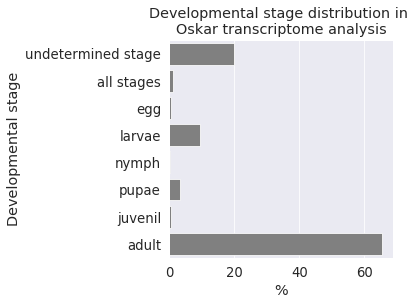

In [16]:
fig = plt.figure(figsize=(4,4))
sns.barplot(data=total_stage_df, x='overal_proportion', y='simple_stage', order=stage_order, color='Gray')

plt.xlabel('%')
plt.ylabel('Developmental stage')
plt.title('Developmental stage distribution in \nOskar transcriptome analysis')

fig.savefig('../Figures/RAW/SVG/Stage_distribution.svg', format='svg')
fig.savefig('../Figures/RAW/PDF/Stage_distribution.pdf', format='pdf')

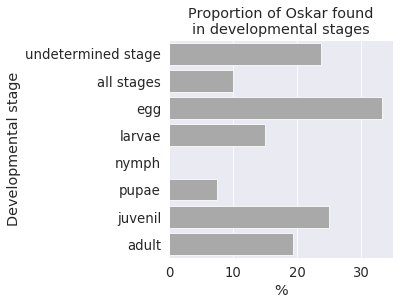

In [17]:
fig = plt.figure(figsize=(4,4))
sns.barplot(data=stage_df[stage_df['oskar'] == 'found'], x='count_proportion', y='simple_stage', order=stage_order, color='darkgray')

plt.xlabel('%')
plt.ylabel('Developmental stage')
plt.title('Proportion of Oskar found\nin developmental stages')


fig.savefig('../Figures/RAW/SVG/Oskar_Stage_distribution.svg', format='svg')
fig.savefig('../Figures/RAW/PDF/Oskar_Stage_distribution.pdf', format='pdf')

### 2. Plots for tissue types

In [27]:
final_tissue = pd.read_csv(os.path.join(data_path, '2.3/oskar_all_tissues.csv'))

In [19]:
search_results = pd.read_csv('../Data/01_Oskar_identification/oskar_tracker_results/search_results.csv')
TSA_search_results = search_results[search_results['source'] == 'TSA']

In [41]:
print("Percent of TSA dataset with sex metadata")
len(final_tissue[~final_tissue['clean_tissue'].isin(['undetermined tissue'])]['tsa_id'].unique()) / len(TSA_search_results)

Percent of TSA dataset with sex metadata


0.2653606411398041

In [19]:
tissue_df = final_tissue.groupby(['clean_tissue', 'oskar'], as_index=False).count()[['clean_tissue', 'oskar', 'species']]
tissue_df = tissue_df.rename(columns={'species':'counts'})
total_tissue_df = final_tissue.groupby(['clean_tissue'], as_index=False).count()[['clean_tissue', 'species']]
tmp = tissue_df.merge(total_tissue_df, on='clean_tissue')
tissue_df['count_proportion'] = tmp['counts']/tmp['species'] * 100
total_tissue_df['overal_proportion'] = total_tissue_df['species']/total_tissue_df['species'].sum() * 100

In [20]:
tissue_df[tissue_df['oskar'] == 'found']

,clean_tissue,oskar,counts,count_proportion
4,blood,found,3,60.000000
6,brain,found,41,45.054945
9,egg,found,2,50.000000
11,fat body,found,4,8.163265
17,gut & fat body & malpighian tubules & glands,found,1,50.000000
19,head,found,3,6.250000
27,malpighian tubules,found,1,20.000000
30,midgut,found,4,9.302326
35,ovaries,found,2,15.384615
42,salivary glands,found,3,30.000000


In [27]:
tissue_order = total_tissue_df.sort_values('overal_proportion')['clean_tissue'].values

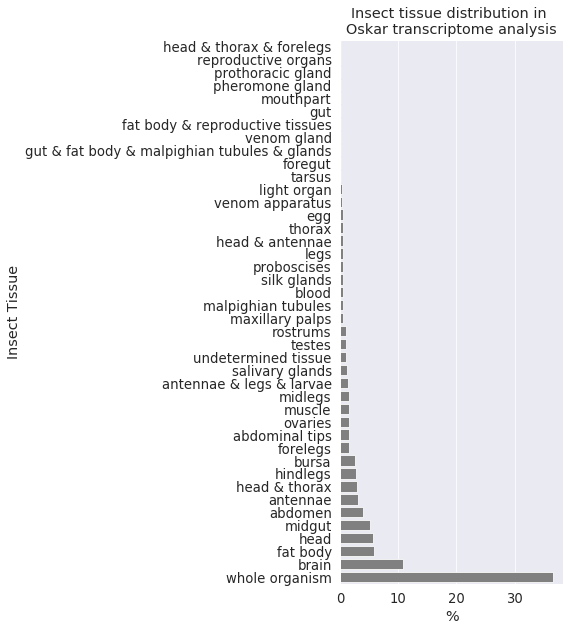

In [41]:
fig = plt.figure(figsize=(4,10))
sns.barplot(data=total_tissue_df, x='overal_proportion', y='clean_tissue', order=tissue_order, color='Gray')

plt.xlabel('%')
plt.ylabel('Insect Tissue')
plt.title('Insect tissue distribution in \nOskar transcriptome analysis')


fig.savefig('../Figures/RAW/SVG/Tissue_distribution.svg', format='svg')
fig.savefig('../Figures/RAW/PDF/Tissue_distribution.pdf', format='pdf')

In [45]:
tissue_df[tissue_df['oskar'] == 'found']

,clean_tissue,oskar,counts,count_proportion
4,blood,found,3,60.000000
6,brain,found,41,45.054945
9,egg,found,2,50.000000
11,fat body,found,4,8.163265
17,gut & fat body & malpighian tubules & glands,found,1,50.000000
19,head,found,3,6.250000
27,malpighian tubules,found,1,20.000000
30,midgut,found,4,9.302326
35,ovaries,found,2,15.384615
42,salivary glands,found,3,30.000000


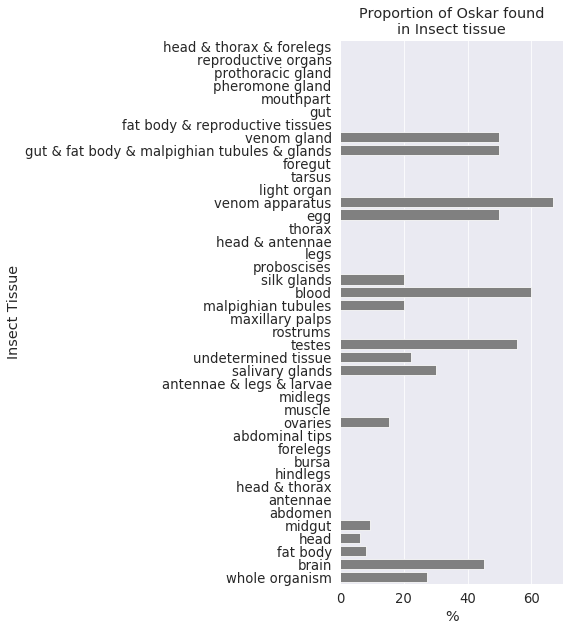

In [42]:
fig = plt.figure(figsize=(4,10))
sns.barplot(data=tissue_df[tissue_df['oskar'] == 'found'], x='count_proportion', y='clean_tissue', order=tissue_order, color='Gray')

plt.xlabel('%')
plt.ylabel('Insect Tissue')
plt.title('Proportion of Oskar found\nin Insect tissue')


fig.savefig('../Figures/RAW/SVG/Oskar_Tissue_distribution.svg', format='svg')
fig.savefig('../Figures/RAW/PDF/Oskar_Tissue_distribution.pdf', format='pdf')

### 4. Preponderant tissue type per order

In [34]:
final_tissue.groupby(['order', 'oskar','clean_tissue']).count()

TSA  tsa_id  family  \
order        oskar     clean_tissue                                           
Blattodea    found     brain                              1       1       1   
             not found abdomen                            1       1       1   
                       antennae                           1       1       1   
                       fat body                           1       1       1   
                       head                               4       4       4   
...                                                     ...     ...     ...   
Siphonaptera not found fat body & reproductive tissues    1       1       1   
                       whole organism                     1       1       1   
Trichoptera  found     whole organism                     2       2       2   
             not found undetermined tissue                1       1       1   
                       whole organism                     2       2       2   

                                                        species  bioproject  \
order        oskar     clean_tissue                                           
Blattodea    found     brain                                  1           1   
             not found abdomen                                1           1   
                       antennae                               1           1   
                       fat body                               1           1   
                       head                                   4           4   
...                                                         ...         ...   
Siphonaptera not found fat body & reproductive tissues        1           1   
                       whole organism                         1           1   
Trichoptera  found     whole organism                         2           2   
             not found undetermined tissue                    1           1   
                       whole organism                         2           2   

                                                        biosample  clean_sex  
order        oskar     clean_tissue                                           
Blattodea    found     brain                                    1          1  
             not found abdomen                                  1          1  
                       antennae                                 1          1  
                       fat body                                 1          1  
                       head                                     4          4  
...                                                           ...        ...  
Siphonaptera not found fat body & reproductive tissues          1          1  
                       whole organism                           1          1  
Trichoptera  found     whole organism                           2          2  
             not found undetermined tissue                      1          1  
                       whole organism                           2          2  

[112 rows x 7 columns]

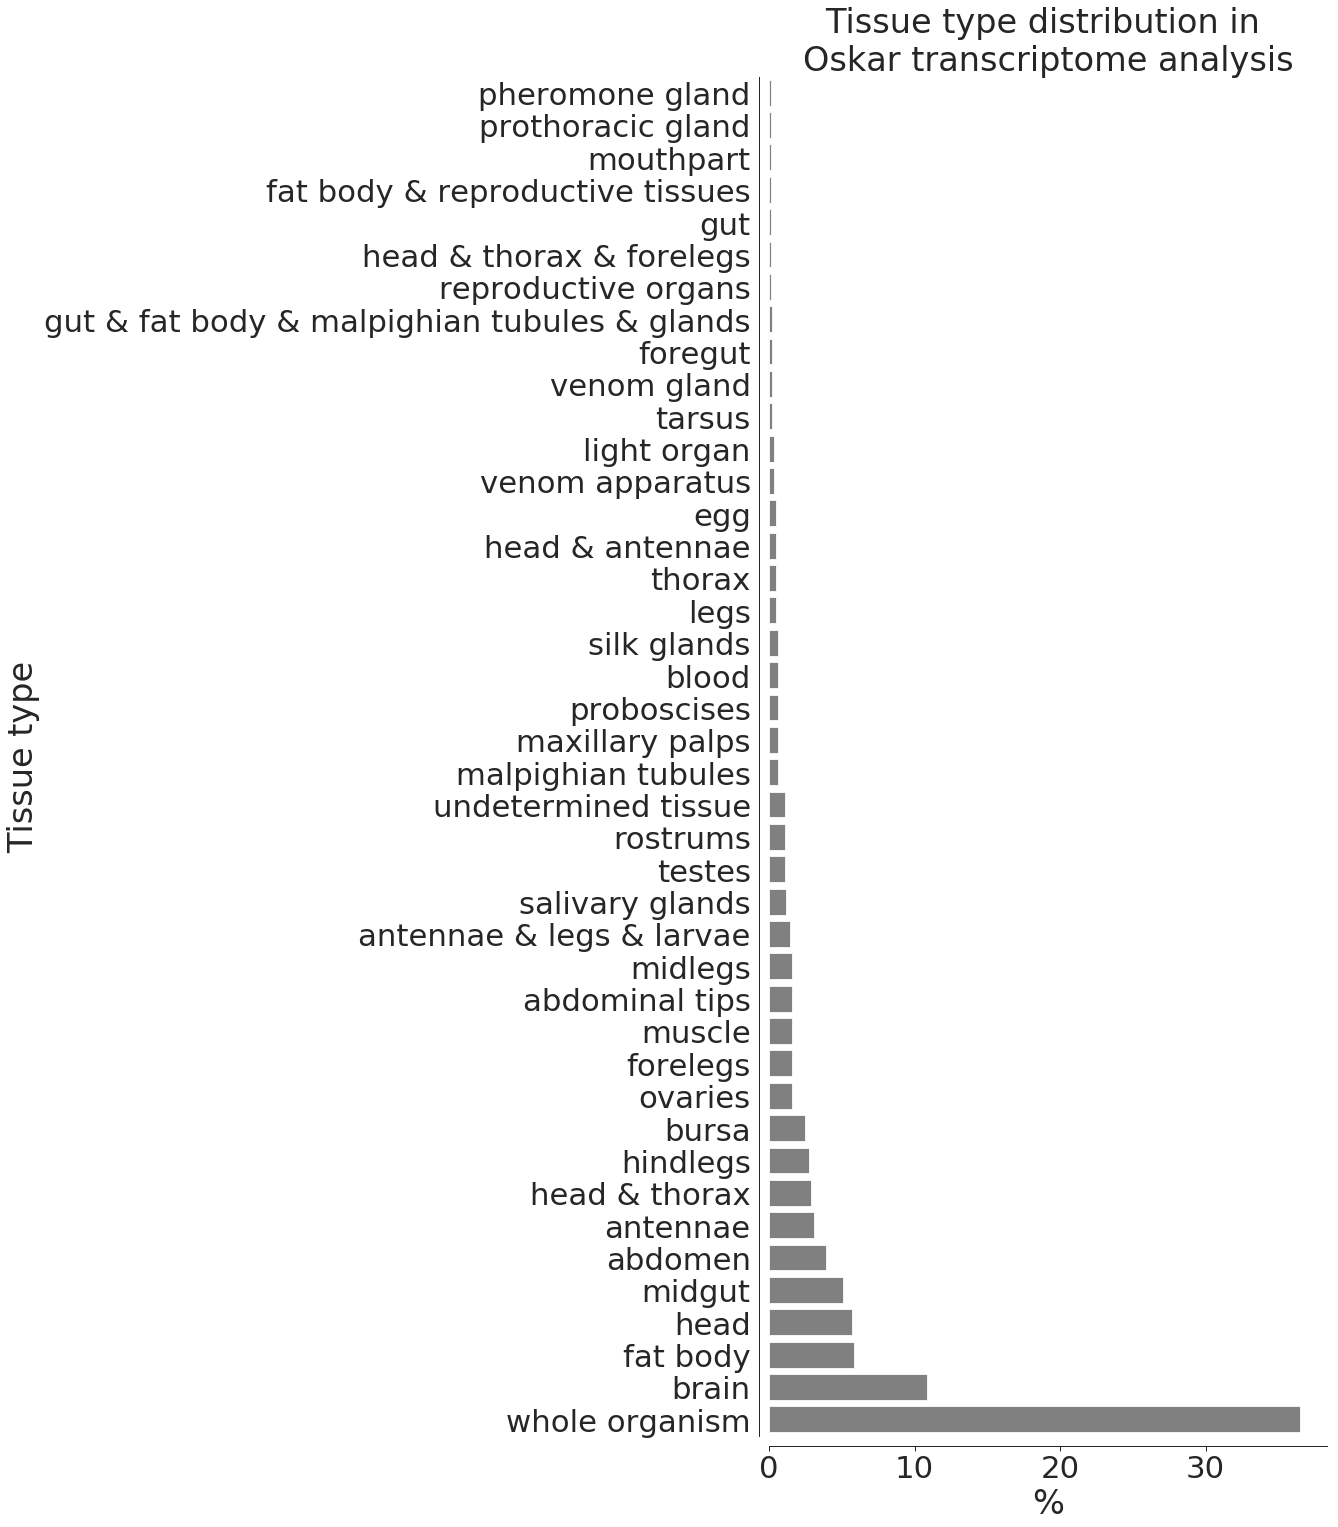

In [36]:
fig = plt.figure(figsize=(10, 25))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=3.5)
sns.set_style("ticks")
sns.despine(offset=10)

sns.barplot(x=tissue_fq['frequency'], y=tissue_fq['tissue'], color='grey')
plt.xlabel('%')
plt.ylabel('Tissue type')
plt.title('Tissue type distribution in \nOskar transcriptome analysis')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True) 

fig.savefig('../Figures/RAW/SVG/Tissue_distribution.svg', format='svg')
fig.savefig('../Figures/RAW/PDF/Tissue_distribution.pdf', format='pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

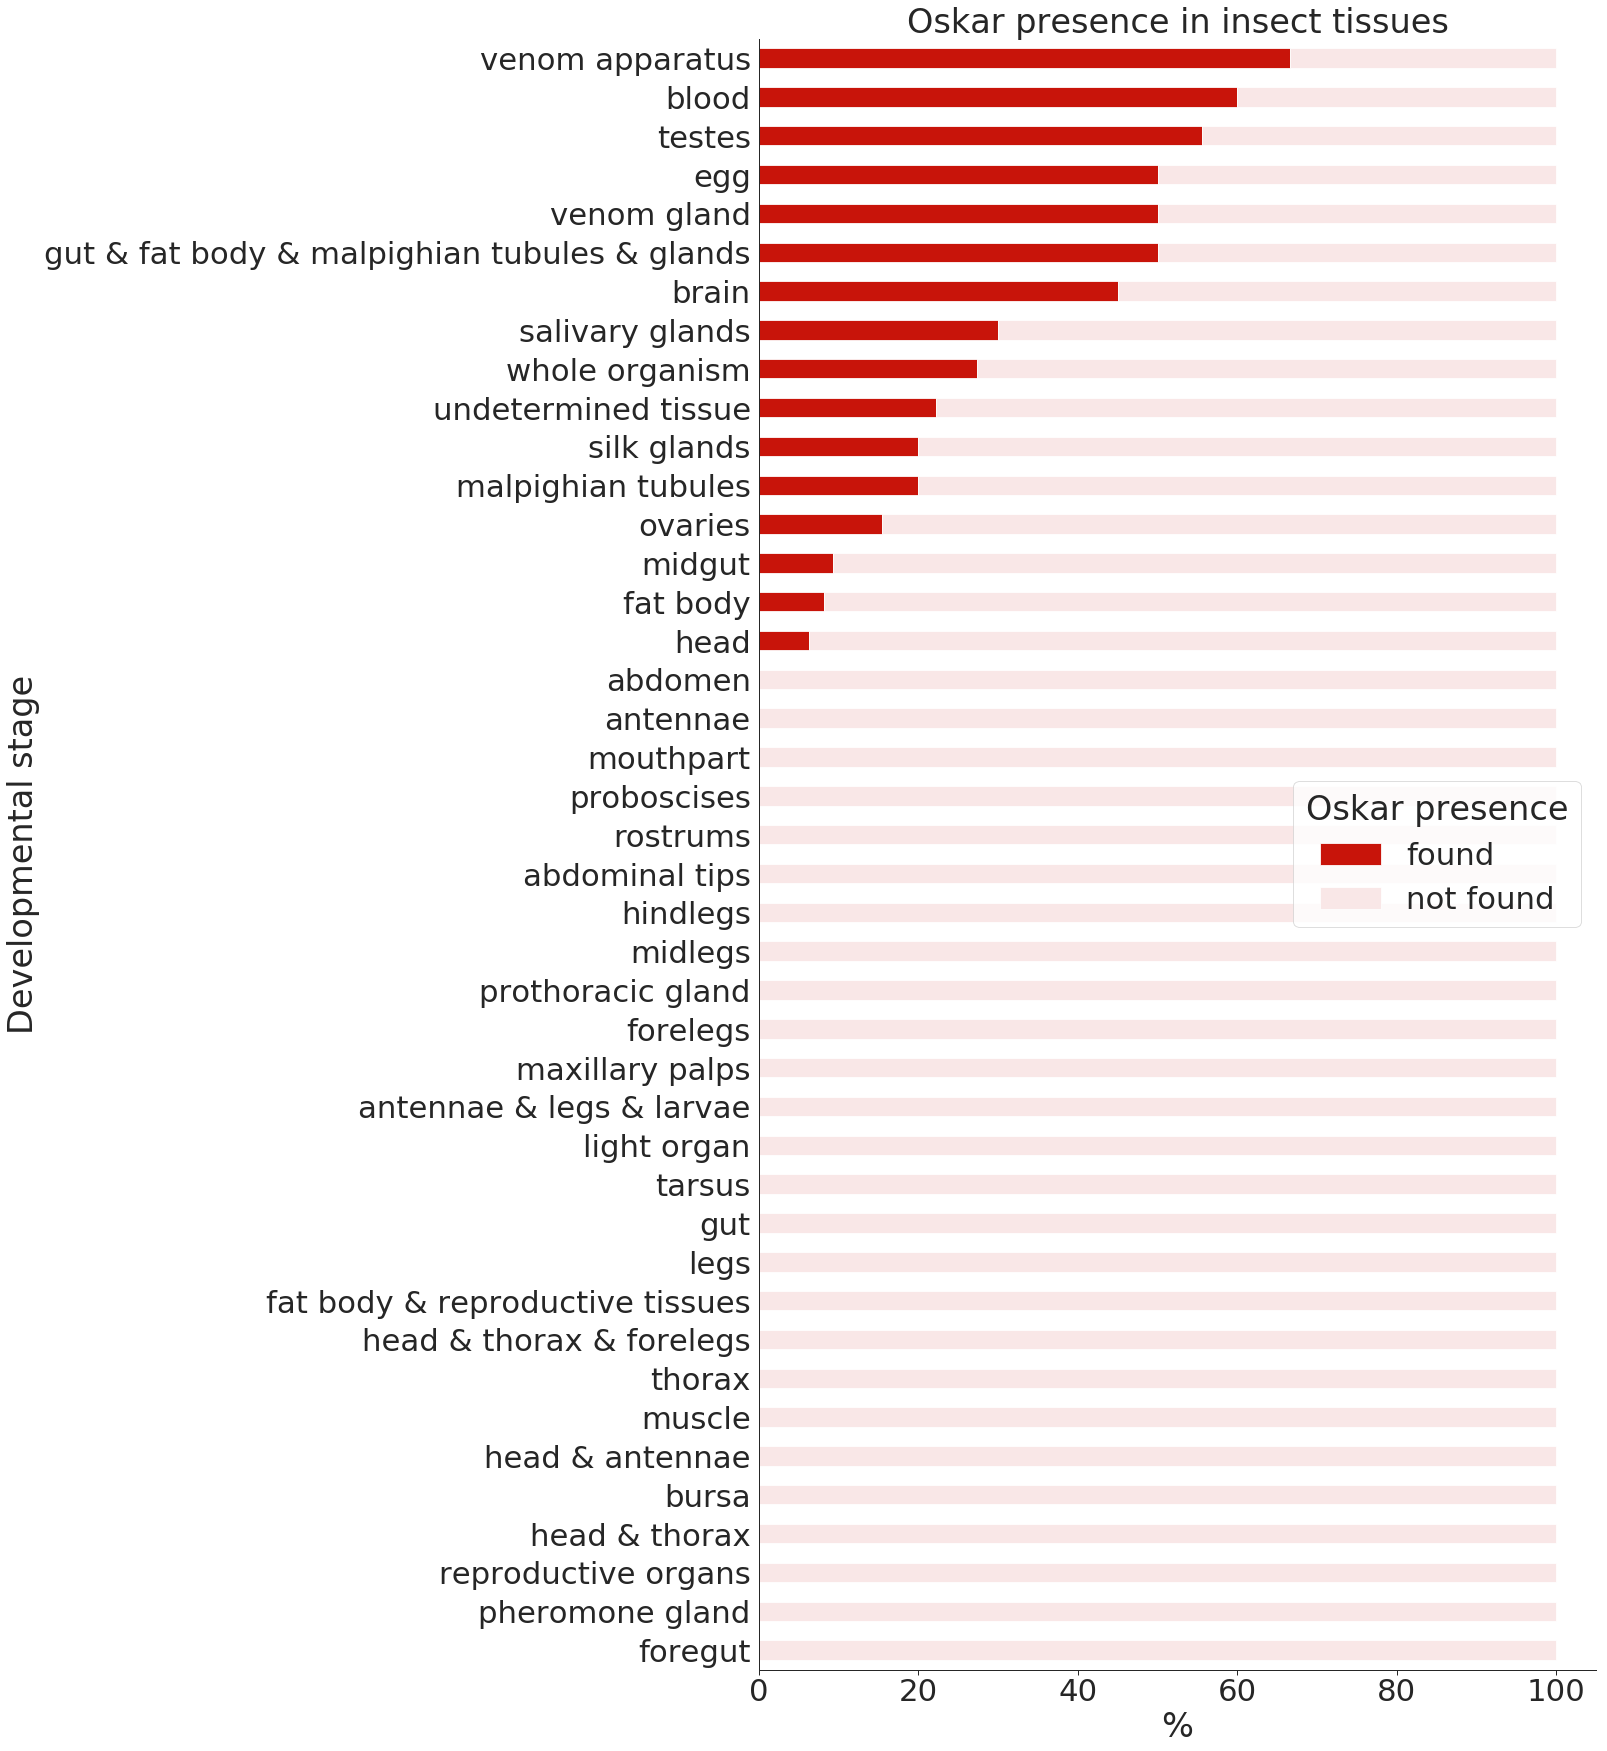

In [37]:
%matplotlib inline
sns.set_context("paper", font_scale=3.5)
sns.set_style("ticks")
sns.despine(offset=10)

oskar_tissue_fq.plot.barh(stacked=True, color=["#c8140a", "#f9e7e7"])
plt.xlabel('%')
plt.ylabel('Developmental stage')
plt.legend(title='Oskar presence', loc='center right')
plt.title('Oskar presence in insect tissues')

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(15, 30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True) 

fig.savefig('../Figures/RAW/SVG/Oskar_tissue_stack.svg', format='svg')
fig.savefig('../Figures/RAW/PDF/Oskar_tissue_stack.pdf', format='pdf')
plt.show()